In [39]:
import pandas as pd
import random
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.svm import SVC


In [40]:
# Get S&P 500 tickers
def get_sp500_tickers(sample_size=350):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]    
    tickers = table['Symbol'].tolist()
    sample_tickers = random.sample(tickers, sample_size)
    return sample_tickers

In [41]:
# Fetch historical data
def get_historical_data(tickers):
    data = pd.DataFrame()
    for i in tickers:
        stock_data = yf.download(i, start="2022-01-01", end="2024-09-10")
        data[i] = stock_data['Adj Close']
    return data

In [42]:
# Perform the ADF test for stationarity
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value

In [43]:
# Calculate z-score for the residuals
def calculate_zscore(residuals):
    mean = residuals.rolling(window=50).mean()
    std = residuals.rolling(window=50).std()
    zscore = (residuals - mean) / std
    return zscore

In [44]:
# Function to calculate half-life based on residuals
def calculate_half_life(residuals):
    residuals_lag = residuals.shift(1).dropna()
    delta_residuals = (residuals - residuals_lag).dropna()
    
    # Regress delta_residuals on residuals_lag to estimate half-life
    regression = OLS(delta_residuals, residuals_lag).fit()
    half_life = -np.log(2) / regression.params[0]
    
    return half_life

In [45]:
# Cointegration test between pairs of stocks with ADF and half-life calculation
def cointegration_test(data):
    pairs = []
    results = []
    residuals_dict = {}

    tickers = data.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            x = data[tickers[i]].dropna()
            y = data[tickers[j]].dropna()

            x, y = x.align(y, join='inner')  # Align x and y by matching labels (dates)
            if x.empty or y.empty:
                continue

            try:
                score, p_value, _ = coint(x, y)
            except ValueError:
                continue

            if p_value < 0.05:  # Cointegration threshold
                # Ratio between the two prices
                ratio = x / y
                adf_p_value = adf_test(ratio)

                if adf_p_value < 0.05:  # ADF stationarity threshold
                    # Store the residuals from the OLS regression
                    ols_result = OLS(x, y).fit()
                    residuals = ols_result.resid

                    # Calculate half-life based on residuals
                    half_life = calculate_half_life(residuals)

                    pairs.append((tickers[i], tickers[j]))
                    results.append((tickers[i], tickers[j], score, p_value, adf_p_value, half_life))
                    residuals_dict[(tickers[i], tickers[j])] = residuals

    results_df = pd.DataFrame(results, columns=['Stock 1', 'Stock 2', 'Cointegration Score', 'Cointegration p-value', 'ADF p-value', 'Half-life'])
    return results_df, residuals_dict

In [46]:
# Function to calculate the average time for z-score to return to 0 after being >1 or <-1
def calculate_avg_reversion_time(zscore):
    threshold_crossings = np.where((zscore > 2) | (zscore < -2))[0]
    reversion_times = []
    
    for crossing in threshold_crossings:
        subsequent_zero_crossings = np.where(np.abs(zscore[crossing:]) < 0.2)[0]  # Closer to 0
        if len(subsequent_zero_crossings) > 0:
            reversion_times.append(subsequent_zero_crossings[0])
    
    if reversion_times:
        return int(np.mean(reversion_times))  # Return average time in days
    else:
        return 21  # Default to 21 days if no crossings

In [47]:
# Generate features and target for ML model
def generate_features_and_target(residuals, zscore):
    residuals = residuals.dropna()
    zscore = zscore.dropna()

    avg_reversion_time = calculate_avg_reversion_time(zscore)

    # Define target: 1 if residuals increase, -1 if decrease after avg_reversion_time
    target = np.where(residuals.shift(-avg_reversion_time) > residuals, 1, -1)

    # Convert target to a pandas Series and drop NaN values
    target = pd.Series(target, index=residuals.index).dropna()

    # Align both zscore and target to have the same index
    common_index = target.index.intersection(zscore.index)
    zscore = zscore.loc[common_index]
    target = target.loc[common_index]

    return zscore, target, avg_reversion_time

In [48]:
# Get S&P 500 tickers and historical data
ticks = get_sp500_tickers()
historical_data = get_historical_data(ticks)

# Cointegration test
results_df, residuals_dict = cointegration_test(historical_data)

# Filter pairs based on cointegration first
cointegrated_pairs = results_df[results_df['Cointegration p-value'] < 0.05]

# Among cointegrated pairs, apply ADF test and half-life ranking
adf_filtered_results = cointegrated_pairs[cointegrated_pairs['ADF p-value'] < 0.05]

# Sort by half-life to prioritize pairs with faster mean reversion
sorted_results = adf_filtered_results.sort_values(by='Half-life', ascending=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [49]:
# Get the top cointegrated pair
top_pair = sorted_results.iloc[0]
stock1, stock2 = top_pair['Stock 1'], top_pair['Stock 2']

# Generate residuals
residuals = residuals_dict[(stock1, stock2)]

# Calculate z-score of the residuals
zscore = calculate_zscore(residuals)

# Generate features and target
features, target, avg_reversion_time = generate_features_and_target(residuals, zscore)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values.reshape(-1, 1), target, test_size=0.3, random_state=42, shuffle=False)

# Train the model
#model = RandomForestClassifier()
model = SVC(kernel='rbf', C=1.0)
#model = LogisticRegression()
#model = KNeighborsClassifier(n_neighbors=5)
#model = GaussianNB()
#model = DecisionTreeClassifier()

model.fit(X_train, y_train)

# Predict signals on the test set
y_pred = model.predict(X_test)

print("historica_data:", historical_data.head())
print("results_df:", cointegrated_pairs.head())
print("cointegrated_pairs:", results_df.head())
print("filtered_results:", adf_filtered_results.head())
print("sorted_results:", sorted_results)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

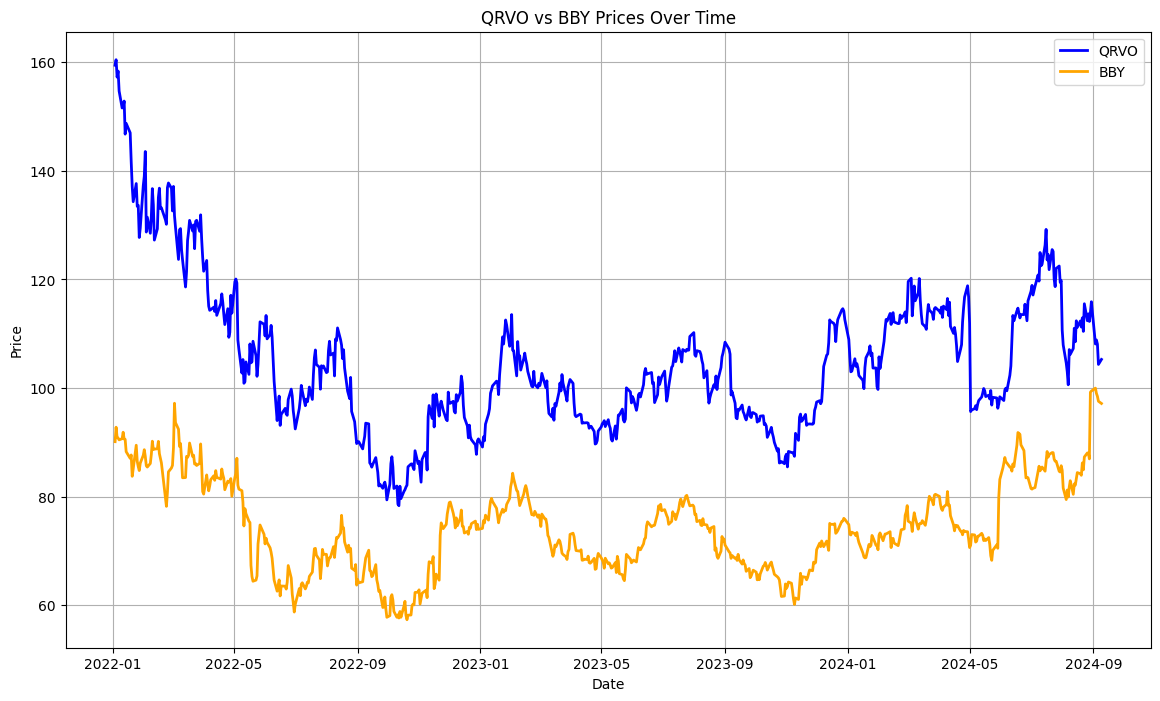

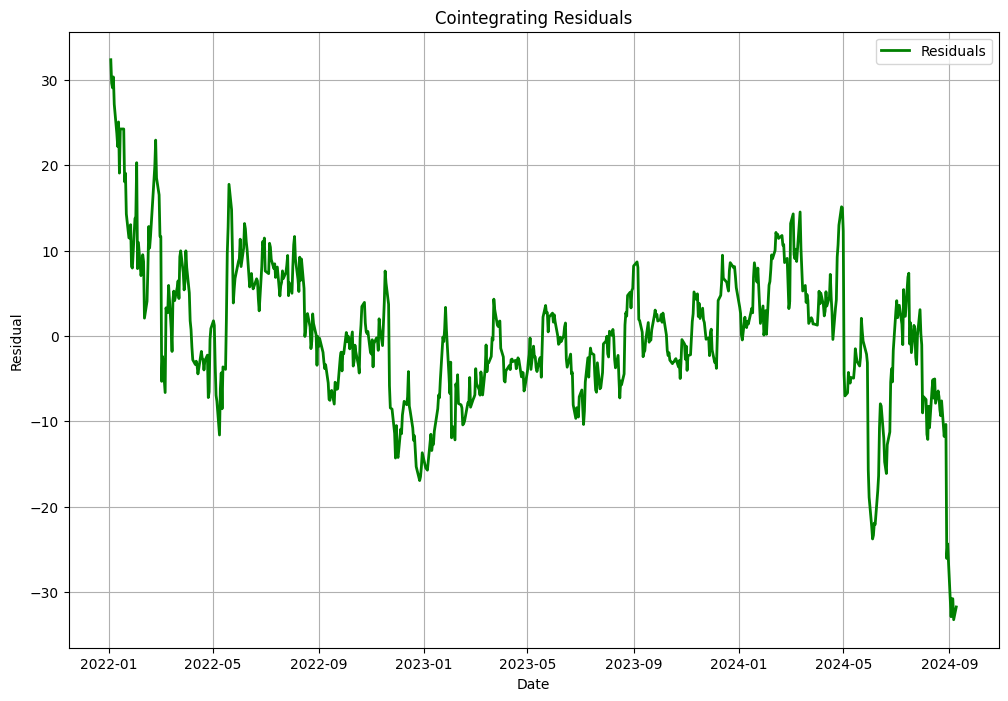

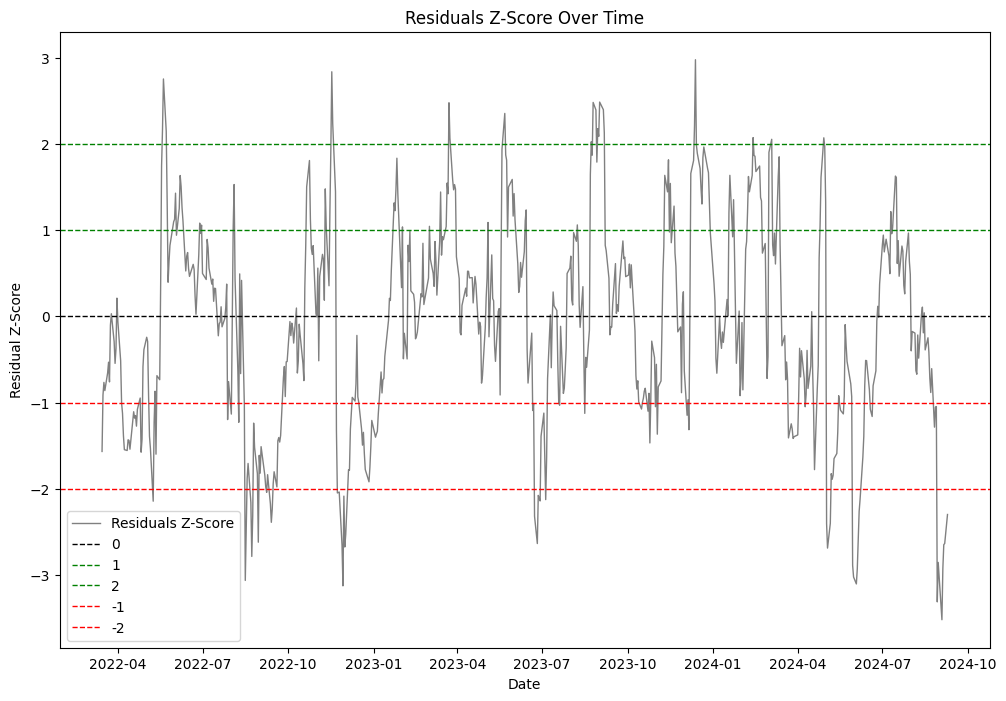

In [12]:
# Plot Stock 1 and Stock 2 Prices
def plot_stocks(stock1, stock2, historical_data):
    plt.figure(figsize=(14, 8))
    
    # Plot stock1 price
    plt.plot(historical_data[stock1], label=stock1, color='blue', linewidth=2)
    
    # Plot stock2 price
    plt.plot(historical_data[stock2], label=stock2, color='orange', linewidth=2)
    
    # Labels and title
    plt.title(f'{stock1} vs {stock2} Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Residuals
def plot_residuals(residuals):
    plt.figure(figsize=(12, 8))
    
    # Plot the residuals of Stock 1 to Stock 2
    plt.plot(residuals, label='Residuals', color='green', linewidth=2)
    
    # Labels and title
    plt.title('Cointegrating Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot residuals zscore
def plot_zscore(zscore):
    plt.figure(figsize=(12, 8))
    plt.plot(zscore, label='Residuals Z-Score', color='gray', linewidth=1)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='0')
    plt.axhline(y=1, color='green', linestyle='--', linewidth=1, label='1')
    plt.axhline(y=2, color='green', linestyle='--', linewidth=1, label='2')
    plt.axhline(y=-1, color='red', linestyle='--', linewidth=1, label='-1')
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1, label='-2')

    # Labels and title
    plt.title('Residuals Z-Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual Z-Score')
    plt.legend()
    plt.show()

# Call the functions to plot
plot_stocks(stock1, stock2, historical_data)
plot_residuals(residuals)
plot_zscore(zscore)

In [15]:
# Define test period stock prices for the top cointegrated pair
stock1_prices_test = historical_data[stock1][-len(y_test):]
stock2_prices_test = historical_data[stock2][-len(y_test):]

# Backtest using ML signals
def backtest_ml_strategy(stock1_prices, stock2_prices, ml_predictions, avg_time):
    positions = []
    returns = []

    position = None
    entry_stock1_price = None
    entry_stock2_price = None
    entry_index = None

    for i in range(len(ml_predictions)):
        # Check if we have an active long position and if it's time to exit
        if position == 'long' and i >= entry_index + avg_time:
            # Register exit for the long position after avg_time days
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]

            # Calculate return for the long position
            long_return = (exit_stock1_price - entry_stock1_price) / entry_stock1_price
            short_return = (entry_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(long_return + short_return)
            positions.append(('exit', i))

            position = None  # Exit the position
            continue  # Skip to the next iteration after exiting

        # Check if we have an active short position and if it's time to exit
        elif position == 'short' and i >= entry_index + avg_time:
            # Register exit for the short position after avg_time days
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]

            # Calculate return for the short position
            short_return = (entry_stock1_price - exit_stock1_price) / entry_stock1_price
            long_return = (exit_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(short_return + long_return)
            positions.append(('exit', i))

            position = None  # Exit the position
            continue  # Skip to the next iteration after exiting

        # Check for new signals only if there's no active position
        if position is None:
            if ml_predictions[i] == 1:
                # Enter long (Long Stock 1, Short Stock 2)
                entry_stock1_price = stock1_prices.iloc[i]
                entry_stock2_price = stock2_prices.iloc[i]
                position = 'long'
                entry_index = i
                positions.append(('long', i))

            elif ml_predictions[i] == -1:
                # Enter short (Short Stock 1, Long Stock 2)
                entry_stock1_price = stock1_prices.iloc[i]
                entry_stock2_price = stock2_prices.iloc[i]
                position = 'short'
                entry_index = i
                positions.append(('short', i))

    return positions, returns

# Backtest strategy
positions, returns = backtest_ml_strategy(stock1_prices_test, stock2_prices_test, y_pred, avg_reversion_time)

# Convert returns to pandas Series
returns = pd.Series(returns)

# Calculating risk-free rate
risk_free_rate = 0.02  # Assuming a 2% annual risk-free rate
daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1  # Adjusted for daily returns

# Excess returns (returns - daily risk-free rate)
excess_returns = returns - daily_risk_free_rate

# Mean of excess returns
mean_excess_return = excess_returns.mean()

# Standard deviation of returns (volatility)
volatility = returns.std()

sharpe_ratio = mean_excess_return / volatility

# Print positions and returns
print("Positions:", positions)
print("Returns:", returns)
print("Total return:", sum(returns))
print(f"Sharpe Ratio: {sharpe_ratio}")

Positions: [('short', 0), ('exit', 18), ('long', 18), ('exit', 36), ('long', 36), ('exit', 54), ('long', 54), ('exit', 72), ('long', 72), ('exit', 90), ('long', 90), ('exit', 108), ('long', 108), ('exit', 126), ('long', 126), ('exit', 144), ('short', 144), ('exit', 162), ('long', 162), ('exit', 180), ('long', 180)]
Returns: 0    0.008175
1    0.033285
2    0.000563
3   -0.010201
4   -0.021363
5   -0.010486
6   -0.146118
7    0.147951
8    0.098254
9   -0.025811
dtype: float64
Total return: 0.07424863192109243
Sharpe Ratio: 0.09409860223518918


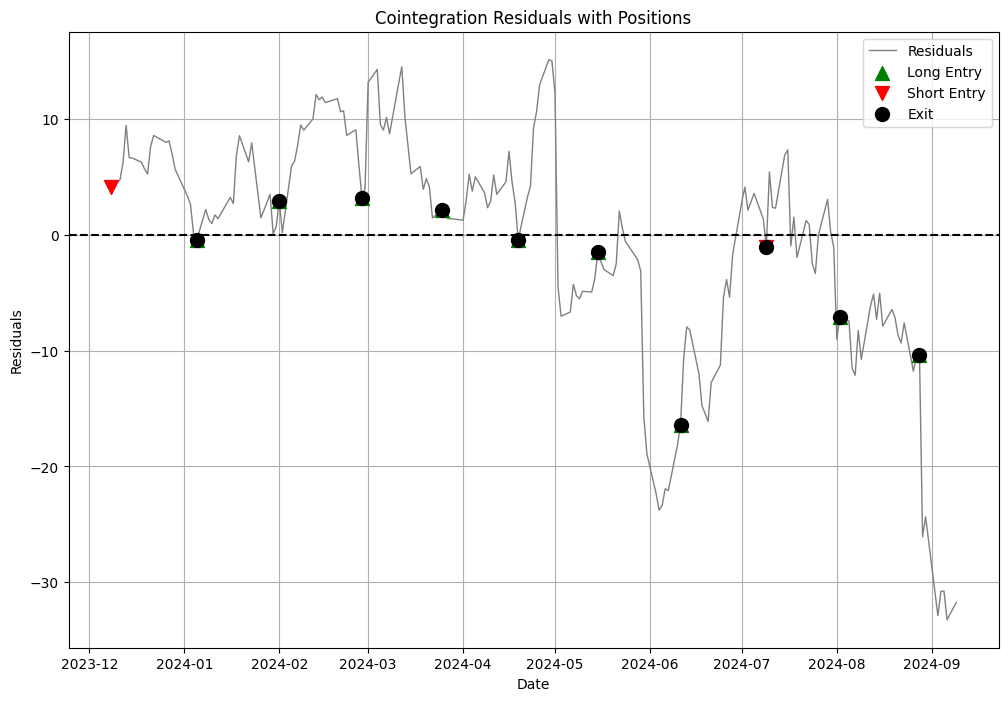

In [16]:
# Plot residuals with positions
def plot_residuals_with_positions(residuals, positions):
    plt.figure(figsize=(12, 8))
    plt.plot(residuals.index, residuals, label="Residuals", color='gray', linewidth=1)

    # Plot long, short, and exit positions
    long_positions = [i for pos, i in positions if pos == 'long']
    short_positions = [i for pos, i in positions if pos == 'short']
    exit_positions = [i for pos, i in positions if pos == 'exit']

    plt.scatter(residuals.index[long_positions], residuals.iloc[long_positions], color='green', marker='^', label='Long Entry', s=100, zorder=5)
    plt.scatter(residuals.index[short_positions], residuals.iloc[short_positions], color='red', marker='v', label='Short Entry', s=100, zorder=5)
    plt.scatter(residuals.index[exit_positions], residuals.iloc[exit_positions], color='black', marker='o', label='Exit', s=100, zorder=5)

    plt.axhline(0, color='black', linestyle='--')
    plt.title("Cointegration Residuals with Positions")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function with the ratio and positions from the backtest
plot_residuals_with_positions(residuals[-len(y_test):], positions)